<div class="alert alert-block alert-success">
    <h1>Portfolio Project # 2</h1>
    <h2>Part 2: Treating Class Imbalance and Comparing Model Results</h2>
    <h3>Coded by: Ariba Khan</h3>
</div>

In this notebook, we will be importing the preprocessed and feature-selected dataset from the previous notebook and applying various class imbalance solutions. After addressing class imbalance, we'll test and compare the performance of different machine learning models.

#### Class Imbalance Treatment Solutions:
- ADASYN (Adaptive Synthetic Sampling)
- Class Weighting
- One-Class Learning

#### Machine Learning Models:
- Logistic Regression
- Random Forest
- XGBoost
- Support Vector Machine (SVM)
- K-Nearest Neighbors (KNN)

At the end of this notebook, we'll compare the results of these models, evaluating their effectiveness on the class-balanced dataset.

<div class="alert alert-block alert-success">
    <h2>Model Performance Before CI Solution</h2>
</div>

#### Importing All Libraries For Notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from xgboost import DMatrix, train as xgb_train
from sklearn.svm import OneClassSVM

#### Viewing Preprocessed Dataset

In [2]:
churn = pd.read_csv("preprocessed_churn_df.csv")

In [3]:
churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
0,-0.330043,0.485817,2,-1.224405,1,1,1,0.021581,1,0,0,1
1,-0.444598,0.371950,1,0.118334,1,0,1,0.216170,0,0,1,0
2,-1.548486,0.485817,8,1.333623,3,1,0,0.240316,1,0,0,1
3,0.503080,0.144217,1,-1.224405,2,0,0,-0.109185,1,0,0,0
4,-0.059278,0.713550,8,0.598149,2,1,0,0.863095,0,0,1,1


In [4]:
churn.shape

(9563, 12)

#### Splitting Target Variable and Features

In [4]:
features = churn.drop('Exited', axis = 1)
target = churn['Exited']

In [5]:
features.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.330043,0.485817,2,-1.224405,1,1,1,0.021581,1,0,0
1,-0.444598,0.371950,1,0.118334,1,0,1,0.216170,0,0,1
2,-1.548486,0.485817,8,1.333623,3,1,0,0.240316,1,0,0


In [7]:
target.head(3)

0    1
1    0
2    1
Name: Exited, dtype: int64

In [6]:
target.value_counts() # checking counts of target classes # 1 = churned, 0 = not churned

Exited
0    7673
1    1890
Name: count, dtype: int64

#### Data Splits for Model Fitting

**Data splits:**
- Training split: 60%
- Validation split: 20%
- Testing split: 20%

*Note: 'stratify = target' in the code ensures that after splitting, the train, validation, and test sets will also have approximately the same class distribution as the original target variable classes.*

In [7]:
## separating 20% test data first

X_train_temp, X_test, y_train_temp, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42, stratify = target)

## splitting the remaining data (80%) into train (60%) and validation (20%)
# note: 25% of 80% is 20% for original dataset

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size = 0.25, random_state = 42, stratify = y_train_temp)

In [8]:
# printing the shapes of the splits to check

print("Train data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)

Train data shape: (5737, 11) (5737,)
Validation data shape: (1913, 11) (1913,)
Test data shape: (1913, 11) (1913,)


#### Model Training / Validation / Testing

In [11]:
# defining the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# defining the performance metrics needed
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# initializing results dictionary
results = {metric: {model_name: {'Training': [], 'Validation': [], 'Test': []} for model_name in models.keys()} for metric in metrics}

# initializing confusion matrices dictionary
conf_matrices = {model_name: None for model_name in models.keys()}

In [12]:
## training and evaluating all models on training set

for model_name, model in models.items():
    # train model
    model.fit(X_train, y_train)
    
    # cross-validation
    y_pred_train = cross_val_predict(model, X_train, y_train, cv=5)
    cv_scores_accuracy = accuracy_score(y_train, y_pred_train)
    cv_scores_precision = precision_score(y_train, y_pred_train)
    cv_scores_recall = recall_score(y_train, y_pred_train)
    cv_scores_f1 = f1_score(y_train, y_pred_train)
    cv_scores_roc_auc = roc_auc_score(y_train, y_pred_train)
    
    # storing training set performance metrics
    results['Accuracy'][model_name]['Training'] = cv_scores_accuracy
    results['Precision'][model_name]['Training'] = cv_scores_precision
    results['Recall'][model_name]['Training'] = cv_scores_recall
    results['F1 Score'][model_name]['Training'] = cv_scores_f1
    results['ROC AUC Score'][model_name]['Training'] = cv_scores_roc_auc

## evaluating models on validation set

for model_name, model in models.items():
    # predictions on validation set
    y_pred_val = model.predict(X_val)
    
    # validation set performance metrics
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1_score = f1_score(y_val, y_pred_val)
    val_roc_auc = roc_auc_score(y_val, y_pred_val)
    
    # storing validation set performance metrics
    results['Accuracy'][model_name]['Validation'] = val_accuracy
    results['Precision'][model_name]['Validation'] = val_precision
    results['Recall'][model_name]['Validation'] = val_recall
    results['F1 Score'][model_name]['Validation'] = val_f1_score
    results['ROC AUC Score'][model_name]['Validation'] = val_roc_auc

## evaluating models on test set

for model_name, model in models.items():
    # predictions on test set
    y_pred_test = model.predict(X_test)
    
    # test set performance metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1_score = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # storing test set performance metrics
    results['Accuracy'][model_name]['Test'] = test_accuracy
    results['Precision'][model_name]['Test'] = test_precision
    results['Recall'][model_name]['Test'] = test_recall
    results['F1 Score'][model_name]['Test'] = test_f1_score
    results['ROC AUC Score'][model_name]['Test'] = test_roc_auc
    conf_matrices[model_name] = conf_matrix

#### Performance Metrics

In [13]:
## creating a dataframe to store all performance metrics

results_data = []

# iterating over each model and metric in train/val/test set
for metric in metrics:
    for model_name in models.keys():
        if metric in results and model_name in results[metric]:
            # appending results to the list
            results_data.append({
                'Model': model_name,
                'Metric': metric,
                'Training': np.mean(results[metric][model_name]['Training']),
                'Validation': results[metric][model_name]['Validation'],
                'Test': results[metric][model_name]['Test']
            })
        else:
            print(f"Missing data for metric: {metric} and model: {model_name}")

# converting the list of dictionaries to a dataframe
df_results = pd.DataFrame(results_data)

In [14]:
df_results #viewing the dataframe

,Model,Metric,Training,Validation,Test
0,Logistic Regression,Accuracy,0.831096,0.831678,0.826451
1,Random Forest,Accuracy,0.856720,0.860429,0.859383
2,XGBoost,Accuracy,0.844344,0.848928,0.842656
3,SVM,Accuracy,0.825867,0.828542,0.821223
4,KNN,Accuracy,0.819418,0.829064,0.811291
5,Logistic Regression,Precision,0.670103,0.691781,0.645570
6,Random Forest,Precision,0.728739,0.763033,0.758294
7,XGBoost,Precision,0.650814,0.661818,0.641026
8,SVM,Precision,0.826087,0.878788,0.750000
9,KNN,Precision,0.585069,0.630769,0.544041


#### Confusion Matrices

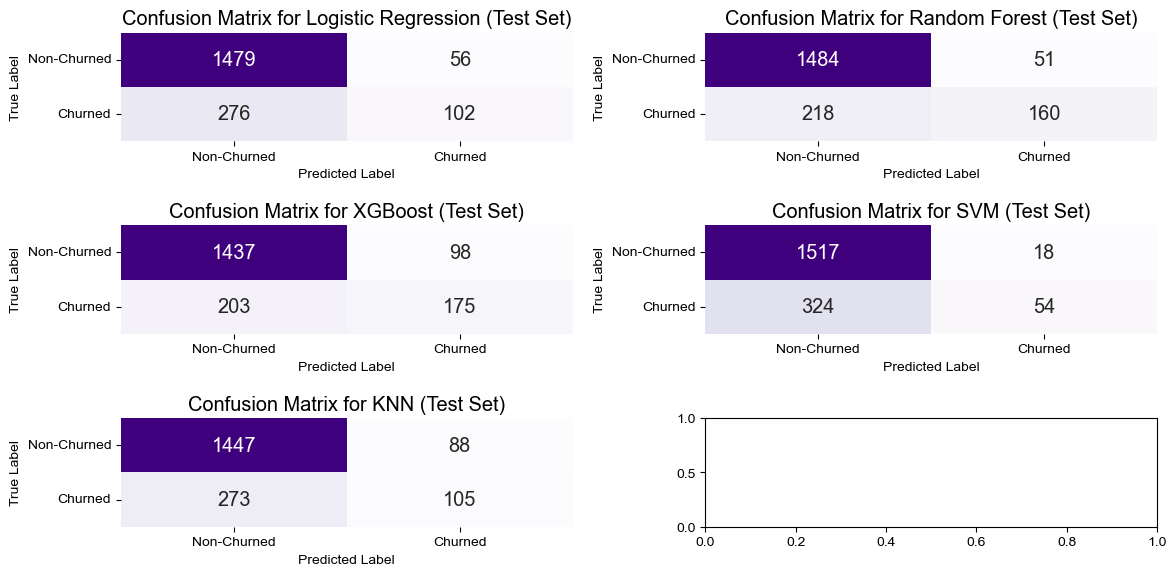

In [15]:
num_rows = int(np.ceil(len(conf_matrices) / 2))
num_cols = 2

# Create a new figure for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterate over each model and its confusion matrix
for i, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    row = i // num_cols
    col = i % num_cols
    
    # Plot the confusion matrix as a subplot
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Purples', cbar=False, 
                xticklabels=['Non-Churned', 'Churned'], yticklabels=['Non-Churned', 'Churned'], ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_title(f'Confusion Matrix for {model_name} (Test Set)')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

#### Interpretation at Baseline


#### Logistic Regression:

In the non-churned set, 1479 individuals were correctly classified, while 56 were misclassified as having churned. 

In the churned set, 276 were misclassified as non-churned while 102 were correctly classified.


#### Random Forest

In the non-churned set, 1484 individuals were correctly classified, while 51 was misclassified as having churned. 

In the churned set, 218 were misclassified as non-churned while 160 was correctly classified.


#### XGBoost

In the non-churned set, 1437 individuals were correctly classified, while 98 were misclassified as having churned. 

In the churned set, 203 were misclassified as non-churned while 175 were correctly classified.


#### SVM

In the non-churned set, 1517 individuals were correctly classified, 18 were misclassified. 

In the churned set, 324 were misclassified as non-churned while 54 were correctly classified.


#### KNN

In the non-churned set, 1447 individuals were correctly classified, while 88 individuals were misclassified as having churned. 

In the churned set, 273 were misclassified as non-churned while 105 was correctly classified.

#### ROC Curves and AUC

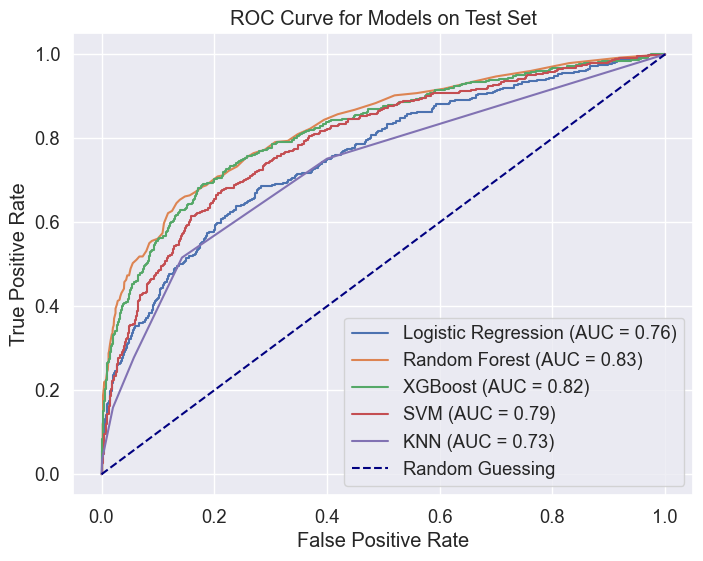

In [16]:
## plotting the ROC curve

plt.figure(figsize=(8, 6))

# iterating over each model
for model_name, model in models.items():
    
    # predicting probabilities or decision scores for positive class
    # note: SVM does not support probability estimation directly so decision scores is used instead
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise AttributeError("Model does not have predict_proba or decision_function method")
    
    # computing ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # plotting ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# plotting ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')

# setting labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Interpretation of the ROC curves and AUC at Baseline

The best performers among the selected models were Random Forest (0.83) and XGBoost (0.82) were almmost similar. SVM (0.79), Logistic Regression (0.76) and KNN (0.73).

All the models performed well. Random Forest were the best and the worst performers among these.

<div class="alert alert-block alert-success">
    <h2>Solution 1: ADASYN</h2>
</div>

#### Transforming Dataset and Class Imbalance

In [17]:
counter = Counter(y_train)
print('Before', counter)

# oversampling the training dataset using ADASYN
ada = ADASYN(random_state = 130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After', counter)

Before Counter({0: 4603, 1: 1134})
After Counter({1: 4709, 0: 4603})


In [18]:
## exporting transformed dataset after ADASYN

# converting X_train_ada and y_train_ada to dataframes
X_train_ada_df = pd.DataFrame(X_train_ada, columns=X_train.columns)
y_train_ada_df = pd.DataFrame(y_train_ada, columns=['Exited'])

# concatenating X_train_ada and y_train_ada dataframes along the columns
churn_ada = pd.concat([X_train_ada_df, y_train_ada_df], axis=1)

# exporting churn_ada dataframe to a CSV file
churn_ada.to_csv('churn_ada.csv', index=False)

In [19]:
churn_ada.head() # viewing the new training dataframe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Exited
0,-1.079854,0.030351,5,1.459860,1,0,1,1.027384,1,0,0,0
1,2.075600,-0.994449,1,-1.224405,2,1,1,1.701692,0,0,1,0
2,-1.569314,-0.425116,4,-1.224405,2,1,0,-1.517150,1,0,0,0
3,0.044862,-0.311249,1,0.093079,2,1,0,-0.196602,0,0,1,0
4,0.836329,0.371950,4,-1.224405,2,1,0,-1.352606,0,0,1,0


In [21]:
churn_ada.shape

(9312, 12)

In [22]:
churn_ada['Exited'].value_counts() # checking class counts of transformed dataframe

Exited
1    4709
0    4603
Name: count, dtype: int64

#### Model Training / Validation / Testing

In [23]:
# defining the models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# defining the performance metrics needed
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# initializing results dictionary
results = {metric: {model_name: {'Training': [], 'Validation': [], 'Test': []} for model_name in models.keys()} for metric in metrics}

# initializing confusion matrices dictionary
conf_matrices = {model_name: None for model_name in models.keys()}

In [24]:
## training and evaluating all models on training set

for model_name, model in models.items():
    # train model
    model.fit(X_train_ada, y_train_ada) # replacing with ADASYN transformed dataset
    
    # cross-validation
    y_pred_train_ada = cross_val_predict(model, X_train_ada, y_train_ada, cv=5)
    cv_scores_accuracy = accuracy_score(y_train_ada, y_pred_train_ada)
    cv_scores_precision = precision_score(y_train_ada, y_pred_train_ada)
    cv_scores_recall = recall_score(y_train_ada, y_pred_train_ada)
    cv_scores_f1 = f1_score(y_train_ada, y_pred_train_ada)
    cv_scores_roc_auc = roc_auc_score(y_train_ada, y_pred_train_ada)
    
    # storing training set performance metrics
    results['Accuracy'][model_name]['Training'] = cv_scores_accuracy
    results['Precision'][model_name]['Training'] = cv_scores_precision
    results['Recall'][model_name]['Training'] = cv_scores_recall
    results['F1 Score'][model_name]['Training'] = cv_scores_f1
    results['ROC AUC Score'][model_name]['Training'] = cv_scores_roc_auc

## evaluating models on validation set

for model_name, model in models.items():
    # predictions on validation set
    y_pred_val = model.predict(X_val)
    
    # validation set performance metrics
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1_score = f1_score(y_val, y_pred_val)
    val_roc_auc = roc_auc_score(y_val, y_pred_val)
    
    # storing validation set performance metrics
    results['Accuracy'][model_name]['Validation'] = val_accuracy
    results['Precision'][model_name]['Validation'] = val_precision
    results['Recall'][model_name]['Validation'] = val_recall
    results['F1 Score'][model_name]['Validation'] = val_f1_score
    results['ROC AUC Score'][model_name]['Validation'] = val_roc_auc

## evaluating models on test set

for model_name, model in models.items():
    # predictions on test set
    y_pred_test = model.predict(X_test)
    
    # test set performance metrics
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1_score = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    # storing test set performance metrics
    results['Accuracy'][model_name]['Test'] = test_accuracy
    results['Precision'][model_name]['Test'] = test_precision
    results['Recall'][model_name]['Test'] = test_recall
    results['F1 Score'][model_name]['Test'] = test_f1_score
    results['ROC AUC Score'][model_name]['Test'] = test_roc_auc
    conf_matrices[model_name] = conf_matrix

#### Performance Metrics

In [25]:
## creating a dataframe to store all performance metrics

results_data_ada = []

# iterating over each model and metric in train/val/test set
for metric in metrics:
    for model_name in models.keys():
        if metric in results and model_name in results[metric]:
            # appending results to the list
            results_data_ada.append({
                'Model': model_name,
                'Metric': metric,
                'Training': np.mean(results[metric][model_name]['Training']),
                'Validation': results[metric][model_name]['Validation'],
                'Test': results[metric][model_name]['Test']
            })
        else:
            print(f"Missing data for metric: {metric} and model: {model_name}")

# converting the list of dictionaries to a dataframe
df_results_ada = pd.DataFrame(results_data_ada)

In [26]:
df_results_ada

,Model,Metric,Training,Validation,Test
0,Logistic Regression,Accuracy,0.742590,0.713539,0.715107
1,Random Forest,Accuracy,0.871671,0.819132,0.813905
2,XGBoost,Accuracy,0.866302,0.813905,0.817564
3,SVM,Accuracy,0.767612,0.729221,0.734449
4,KNN,Accuracy,0.835696,0.716675,0.709880
5,Logistic Regression,Precision,0.747432,0.371988,0.368504
6,Random Forest,Precision,0.871145,0.538278,0.526066
7,XGBoost,Precision,0.880325,0.527638,0.536341
8,SVM,Precision,0.761885,0.394895,0.397799
9,KNN,Precision,0.787692,0.373065,0.353719


#### Confusion Matrices

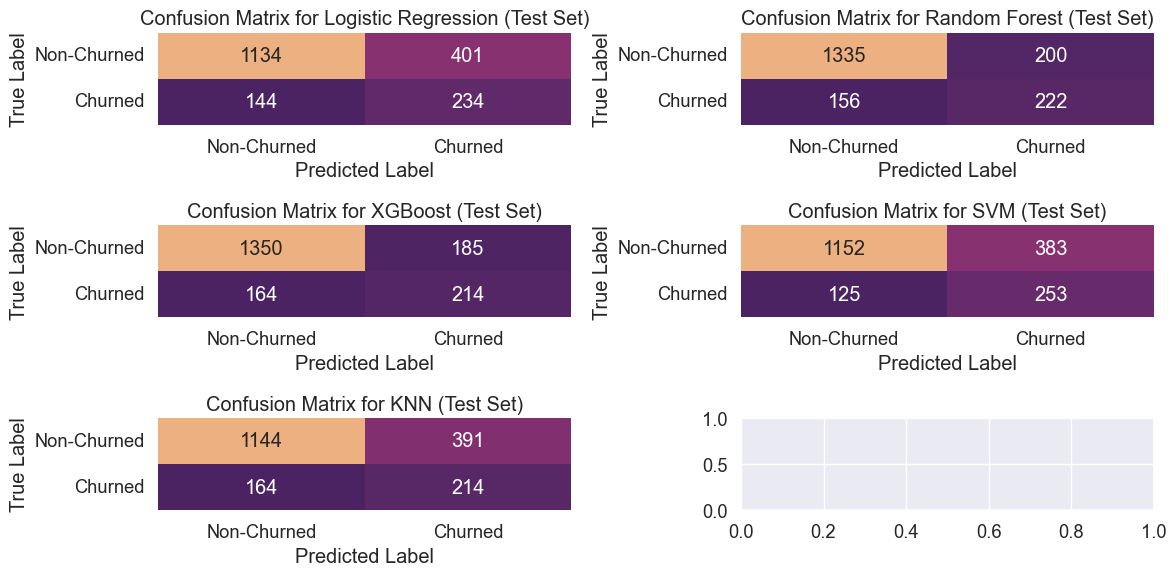

In [30]:
num_rows = int(np.ceil(len(conf_matrices) / 2))
num_cols = 2

# Create a new figure for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterate over each model and its confusion matrix
for i, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    row = i // num_cols
    col = i % num_cols
    
    # Plot the confusion matrix as a subplot
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='flare_r', cbar=False, 
                xticklabels=['Non-Churned', 'Churned'], yticklabels=['Non-Churned', 'Churned'], ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_title(f'Confusion Matrix for {model_name} (Test Set)')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

#### Interpretation using ADASYN

#### Logistic Regression:

In the non-churned set, 1134 individuals were correctly classified, while 401 were misclassified as having churned. 

In the churned set, 144 were misclassified as non-churned while 234 were correctly classified.


#### Random Forest

In the non-churned set, 1335 individuals were correctly classified, while 200 were misclassified as having churned. 

In the churned set, 156 were misclassified as non-churned while 222 was correctly classified.


#### XGBoost

In the non-churned set, 1350 individuals were correctly classified, while 185 were misclassified as having churned. 

In the churned set, 164 were misclassified as non-churned while 214 were correctly classified.


#### SVM

In the non-churned set, 1152 individuals were correctly classified, 383 were misclassified. 

In the churned set, 125 were misclassified as non-churned while 253 were correctly classified.


#### KNN

In the non-churned set, 1144 individuals were correctly classified, while 391 individuals were misclassified as having churned. 

In the churned set, 164 were misclassified as non-churned while 214 was correctly classified.

#### ROC Curves and AUC

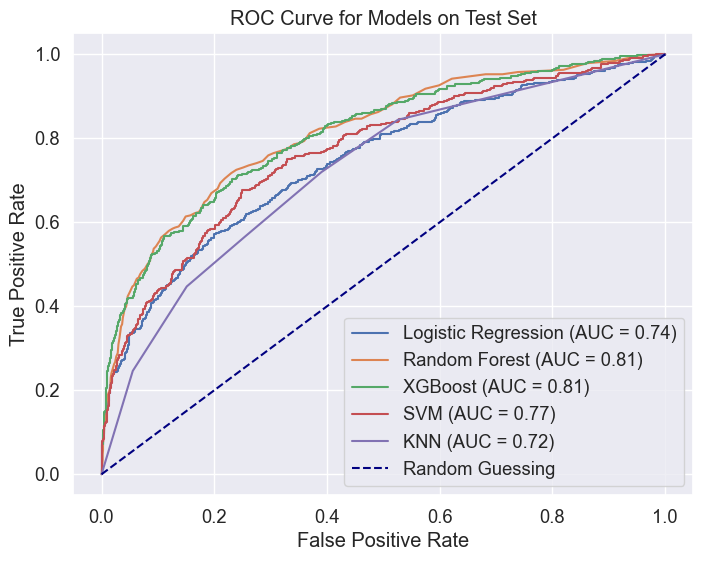

In [28]:
## plotting the ROC curve

plt.figure(figsize=(8, 6))

# iterating over each model
for model_name, model in models.items():
    
    # predicting probabilities or decision scores for positive class
    # note: SVM does not support probability estimation directly so decision scores is used instead
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise AttributeError("Model does not have predict_proba or decision_function method")
    
    # computing ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # plotting ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# plotting ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')

# setting labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Interpretation of the ROC curves and AUC at Baseline

The best performers among the selected models were Random Forest and XGBoost (0.81) were at par. SVM (0.77), Logistic Regression (0.74) and KNN (0.72) were reasonably well performers.

<div class="alert alert-block alert-success">
    <h2>Solution 2: Class Weighting</h2>
</div>

#### Finding Appropriate Class Weights for Each Model

In [35]:
## defining a model to perform grid search to find optimal class weights for each model

def grid_search_with_class_weights(model, X_train, y_train):
    # Setting the range for class weights
    weights = np.linspace(0.0, 0.99, 200)

    # creating a dictionary grid for grid search
    param_grid = {'class_weight': [{0: x, 1: 1.0 - x} for x in weights]}

    # fitting grid search to the train data with 5 folds
    gridsearch = GridSearchCV(estimator=model, 
                              param_grid=param_grid,
                              cv=StratifiedKFold(), 
                              n_jobs=-1, 
                              scoring='f1', 
                              verbose=2).fit(X_train, y_train)
    
    # retrieving the best parameters from the grid search
    best_params = gridsearch.best_params_
    best_class_weights = best_params['class_weight']
    
    # printing the best class weights and best mean F1 score
    print("Best class weights:", best_class_weights)
    print("Best mean F1 score:", gridsearch.best_score_)
    
    return best_class_weights

In [12]:
## declaring models and best class weights dictionary
# note: class weighting does not apply to KNN algorithm as it is distance-based

models = {
    'Logistic Regression': LogisticRegression(solver='newton-cg'),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'SVM': SVC()
}

In [37]:
# running grid search model

best_class_weights = {}
for model_name, model in models.items():
    print("Grid search for", model_name)
    best_class_weights[model_name] = grid_search_with_class_weights(model, X_train, y_train)

Grid search for Logistic Regression
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best class weights: {0: 0.2736180904522613, 1: 0.7263819095477386}
Best mean F1 score: 0.5265223935817509
Grid search for Random Forest
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best class weights: {0: 0.7860301507537689, 1: 0.21396984924623108}
Best mean F1 score: 0.5607906985189253
Grid search for XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best class weights: {0: 0.0, 1: 1.0}
Best mean F1 score: 0.5373466864456692
Grid search for SVM
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best class weights: {0: 0.22386934673366835, 1: 0.7761306532663317}
Best mean F1 score: 0.5375061339350787


#### Model Training / Validation / Testing

In [13]:
best_class_weights = {
    'Logistic Regression': {0: 0.2736180904522613, 1: 0.7263819095477386},
    'Random Forest': {0: 0.7860301507537689, 1: 0.21396984924623108},
    'XGBoost': {0: 0.0, 1: 1.0},
    'SVM': {0: 0.22386934673366835, 1: 0.7761306532663317}
}

In [14]:
# defining the performance metrics needed
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# initializing results dictionary
results = {metric: {model_name: {'Training': [], 'Validation': [], 'Test': []} for model_name in models.keys()} for metric in metrics}

# initializing confusion matrices dictionary
conf_matrices = {model_name: None for model_name in models.keys()}

In [16]:
### training and evaluating models with best class weights

for model_name, model in models.items():
    
    # Setting the class weights
    if model_name == 'XGBoost':
        if best_class_weights[model_name][0] != 0:
            model.set_params(scale_pos_weight=best_class_weights[model_name][1] / best_class_weights[model_name][0])
        else:
            print(f"Skipping setting class weights for {model_name} due to zero division risk.")
    else:
        if model_name in best_class_weights:
            model.set_params(class_weight=best_class_weights[model_name])
        
    ## train model
    model.fit(X_train, y_train)
    
    # predictions on training set
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_roc_auc = roc_auc_score(y_train, y_pred_train)
    
    # storing training set performance metrics
    results['Accuracy'][model_name]['Training'] = train_accuracy
    results['Precision'][model_name]['Training'] = train_precision
    results['Recall'][model_name]['Training'] = train_recall
    results['F1 Score'][model_name]['Training'] = train_f1
    results['ROC AUC Score'][model_name]['Training'] = train_roc_auc
    
    ## predictions on validation set
    y_pred_val = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_precision = precision_score(y_val, y_pred_val)
    val_recall = recall_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val)
    val_roc_auc = roc_auc_score(y_val, y_pred_val)
    
    # storing validation set performance metrics
    results['Accuracy'][model_name]['Validation'] = val_accuracy
    results['Precision'][model_name]['Validation'] = val_precision
    results['Recall'][model_name]['Validation'] = val_recall
    results['F1 Score'][model_name]['Validation'] = val_f1
    results['ROC AUC Score'][model_name]['Validation'] = val_roc_auc
    
    ## predictions on test set
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_pred_test)
    
    # storing test set performance metrics
    results['Accuracy'][model_name]['Test'] = test_accuracy
    results['Precision'][model_name]['Test'] = test_precision
    results['Recall'][model_name]['Test'] = test_recall
    results['F1 Score'][model_name]['Test'] = test_f1
    results['ROC AUC Score'][model_name]['Test'] = test_roc_auc
    
    # storing confusion matrix for test set
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    conf_matrices[model_name] = conf_matrix

Skipping setting class weights for XGBoost due to zero division risk.


#### Performance Metrics

In [17]:
## creating a dataframe to store all performance metrics

results_data_cw = []

# iterating over each model and metric in train/val/test set
for metric in metrics:
    for model_name in models.keys():
        if metric in results and model_name in results[metric]:
            # appending results to the list
            results_data_cw.append({
                'Model': model_name,
                'Metric': metric,
                'Training': np.mean(results[metric][model_name]['Training']),
                'Validation': results[metric][model_name]['Validation'],
                'Test': results[metric][model_name]['Test']
            })
        else:
            print(f"Missing data for metric: {metric} and model: {model_name}")

# converting the list of dictionaries to a dataframe
df_results_cw = pd.DataFrame(results_data_cw)

In [18]:
df_results_cw

,Model,Metric,Training,Validation,Test
0,Logistic Regression,Accuracy,0.791006,0.787768,0.777313
1,Random Forest,Accuracy,1.000000,0.860429,0.858860
2,XGBoost,Accuracy,0.977340,0.848928,0.842656
3,SVM,Accuracy,0.788043,0.778881,0.774177
4,Logistic Regression,Precision,0.476568,0.469565,0.446188
5,Random Forest,Precision,1.000000,0.734177,0.726891
6,XGBoost,Precision,0.988327,0.661818,0.641026
7,SVM,Precision,0.473919,0.457467,0.445565
8,Logistic Regression,Recall,0.582892,0.571429,0.526455
9,Random Forest,Recall,1.000000,0.460317,0.457672


#### Confusion Matrices

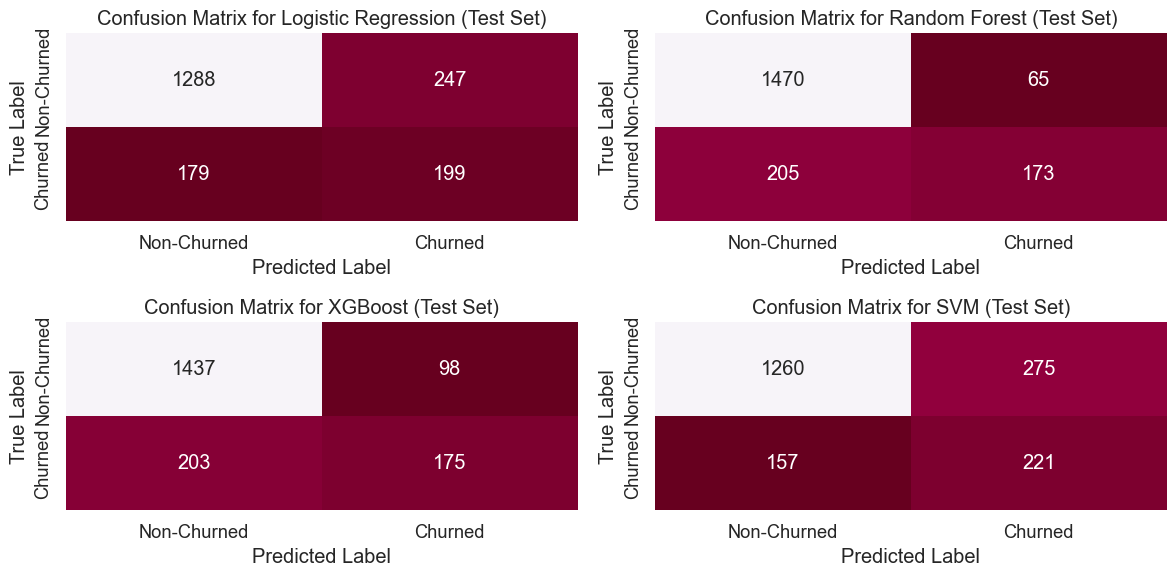

In [20]:
num_rows = int(np.ceil(len(conf_matrices) / 2))
num_cols = 2

# Create a new figure for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterate over each model and its confusion matrix
for i, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    row = i // num_cols
    col = i % num_cols
    
    # Plot the confusion matrix as a subplot
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='PuRd_r', cbar=False, 
                xticklabels=['Non-Churned', 'Churned'], yticklabels=['Non-Churned', 'Churned'], ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_title(f'Confusion Matrix for {model_name} (Test Set)')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

#### Interpretation for Class Weighting


#### Logistic Regression:

In the non-churned set, 1288 individuals were correctly classified, while 247 5were misclassified as having churned. 

In the churned set, 179 were misclassified as non-churned while 199 were correctly classified.


#### Random Forest

In the non-churned set, 1470 individuals were correctly classified, while 65 were misclassified as having churned. 

In the churned set, 205 were misclassified as non-churned while 173 was correctly classified.


#### XGBoost

In the non-churned set, 1437 individuals were correctly classified, while 98 were misclassified as having churned. 

In the churned set, 203 were misclassified as non-churned while 175 were correctly classified.


#### SVM

In the non-churned set, 1260 individuals were correctly classified, 275 were misclassified. 

In the churned set, 157 were misclassified as non-churned while 221 were correctly classified.

#### ROC Curves and AUC

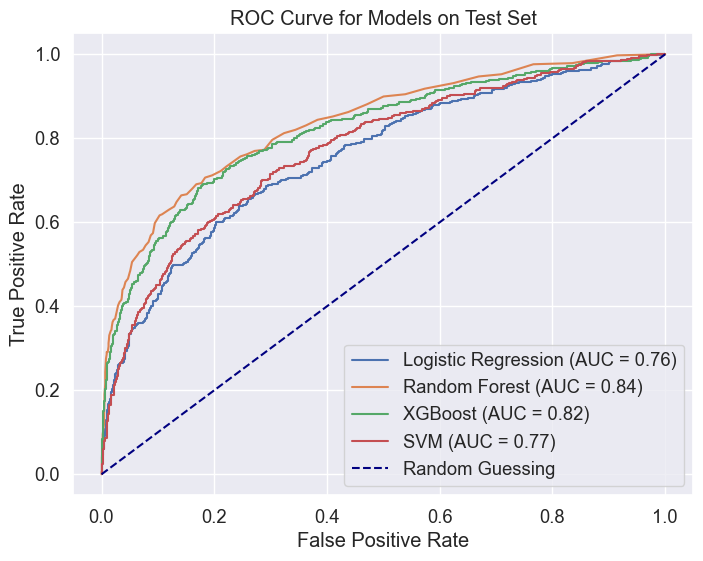

In [21]:
## plotting the ROC curve

plt.figure(figsize=(8, 6))

# iterating over each model
for model_name, model in models.items():
    
    # predicting probabilities or decision scores for positive class
    # note: SVM does not support probability estimation directly so decision scores is used instead
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        raise AttributeError("Model does not have predict_proba or decision_function method")
    
    # computing ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    # plotting ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# plotting ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')

# setting labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Interpretation of the ROC curves and AUC

The best performers among the selected models were  Random Forest (0.84), followed by XGBoost (0.84), SVM (0.77), and Logistic Regression (0.73). These three models were in a similar range. Logistic Regression performed poorly among the four selected models.

<div class="alert alert-block alert-success">
    <h2>Solution 3: One-Class Learning</h2>
</div>

#### Model Training / Validation / Testing

In [34]:
# defining the models
models = {
    'Random Forest': IsolationForest(contamination=0.1),  # using IsolationForest for anomaly detection
    'XGBoost': XGBClassifier(),
    'SVM': OneClassSVM(kernel='rbf', gamma='auto'),
    'KNN': NearestNeighbors(n_neighbors=5)  # using nearest neighbors for anomaly detection
}

# defining the performance metrics needed
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score']

# initializing results dictionary
results = {metric: {model_name: {'Training': [], 'Validation': [], 'Test': []} for model_name in models.keys()} for metric in metrics}

# initializing confusion matrices dictionary
conf_matrices = {model_name: None for model_name in models.keys()}

X_minority = X_train[y_train == 1]  # choosing all rows where the target class is '1'
y_minority = y_train[y_train == 1]

In [35]:
def evaluate_model(model_name, y_true, y_pred, data_type):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    results['Accuracy'][model_name][data_type] = accuracy
    results['Precision'][model_name][data_type] = precision
    results['Recall'][model_name][data_type] = recall
    results['F1 Score'][model_name][data_type] = f1
    results['ROC AUC Score'][model_name][data_type] = roc_auc

    return confusion_matrix(y_true, y_pred)

In [36]:
for model_name, model in models.items():

    if model_name == 'Random Forest':
        # Train Isolation Forest on the whole dataset
        model.fit(X_train)
        
        # Predictions (anomaly detection)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
        
        # Convert -1 (outliers) to 1 and 1 (inliers) to 0
        y_pred_train = np.where(y_pred_train == -1, 1, 0)
        y_pred_val = np.where(y_pred_val == -1, 1, 0)
        y_pred_test = np.where(y_pred_test == -1, 1, 0)

    elif model_name == 'XGBoost':
        # Train XGBoost on minority class
        dtrain = DMatrix(X_minority, label=y_minority)
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss'
        }
        bst = xgb_train(params, dtrain, num_boost_round=100)
        
        # To make predictions
        dtest_train = DMatrix(X_train)
        y_pred_train = bst.predict(dtest_train)
        y_pred_train = np.round(y_pred_train).astype(int)
        
        dtest_val = DMatrix(X_val)
        y_pred_val = bst.predict(dtest_val)
        y_pred_val = np.round(y_pred_val).astype(int)
        
        dtest_test = DMatrix(X_test)
        y_pred_test = bst.predict(dtest_test)
        y_pred_test = np.round(y_pred_test).astype(int)

    elif model_name == 'SVM':
        # Train One-Class SVM on minority class
        model.fit(X_minority)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
        
        # Convert -1 (outliers) to 1 and 1 (inliers) to 0
        y_pred_train = np.where(y_pred_train == -1, 1, 0)
        y_pred_val = np.where(y_pred_val == -1, 1, 0)
        y_pred_test = np.where(y_pred_test == -1, 1, 0)

    elif model_name == 'KNN':
        # Train Nearest Neighbors on minority class
        model.fit(X_minority)
        
        # Use KNN for anomaly detection
        distances, _ = model.kneighbors(X_train)
        y_pred_train = (distances.mean(axis=1) > np.percentile(distances.mean(axis=1), 90)).astype(int)
        
        distances, _ = model.kneighbors(X_val)
        y_pred_val = (distances.mean(axis=1) > np.percentile(distances.mean(axis=1), 90)).astype(int)
        
        distances, _ = model.kneighbors(X_test)
        y_pred_test = (distances.mean(axis=1) > np.percentile(distances.mean(axis=1), 90)).astype(int)

    # Store the performance metrics
    conf_matrices[model_name] = evaluate_model(model_name, y_train, y_pred_train, 'Training')
    conf_matrices[model_name] = evaluate_model(model_name, y_val, y_pred_val, 'Validation')
    conf_matrices[model_name] = evaluate_model(model_name, y_test, y_pred_test, 'Test')

#### Performance Metrics

In [39]:
## creating a dataframe to store all performance metrics

results_data_ocl = []

# iterating over each model and metric in train/val/test set
for metric in metrics:
    for model_name in models.keys():
        if metric in results and model_name in results[metric]:
            # appending results to the list
            results_data_ocl.append({
                'Model': model_name,
                'Metric': metric,
                'Training': np.mean(results[metric][model_name]['Training']),
                'Validation': results[metric][model_name]['Validation'],
                'Test': results[metric][model_name]['Test']
            })
        else:
            print(f"Missing data for metric: {metric} and model: {model_name}")

# converting the list of dictionaries to a dataframe
df_results_ocl = pd.DataFrame(results_data_ocl)

In [41]:
df_results_ocl

,Model,Metric,Training,Validation,Test
0,Random Forest,Accuracy,0.777584,0.785154,0.775745
1,XGBoost,Accuracy,0.197664,0.197595,0.197595
2,SVM,Accuracy,0.436465,0.437533,0.425510
3,KNN,Accuracy,0.703329,0.734449,0.736539
4,Random Forest,Precision,0.376307,0.424658,0.365079
5,XGBoost,Precision,0.197664,0.197595,0.197595
6,SVM,Precision,0.175780,0.182149,0.168962
7,KNN,Precision,0.005226,0.161458,0.171875
8,Random Forest,Recall,0.190476,0.246032,0.182540
9,XGBoost,Recall,1.000000,1.000000,1.000000


#### Confusion Matrices

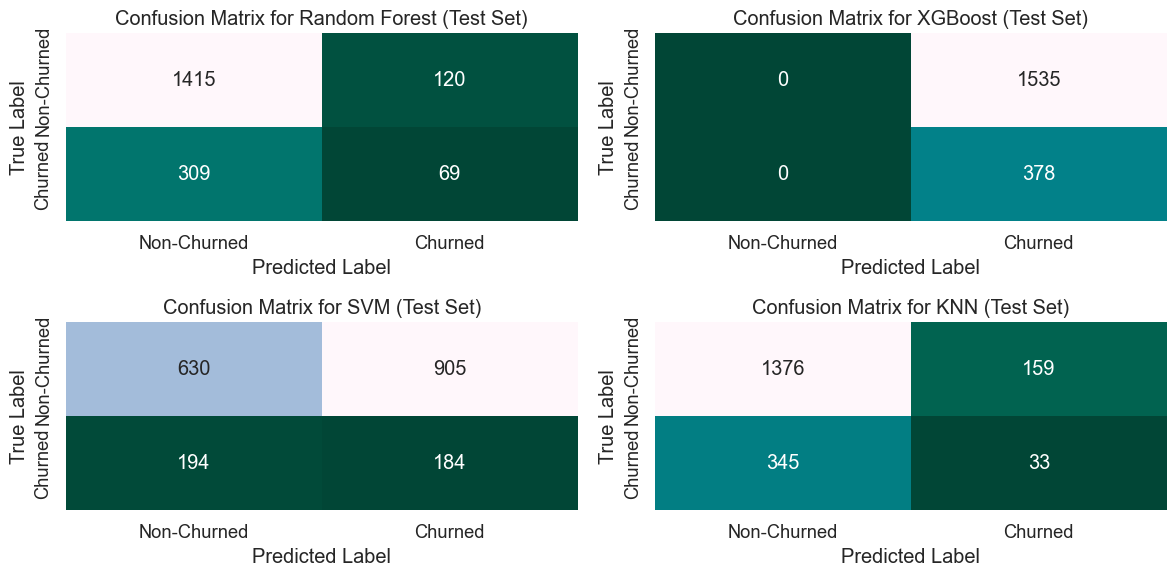

In [43]:
num_rows = int(np.ceil(len(conf_matrices) / 2))
num_cols = 2

# Create a new figure for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Iterate over each model and its confusion matrix
for i, (model_name, conf_matrix) in enumerate(conf_matrices.items()):
    row = i // num_cols
    col = i % num_cols
    
    # Plot the confusion matrix as a subplot
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='PuBuGn_r', cbar=False, 
                xticklabels=['Non-Churned', 'Churned'], yticklabels=['Non-Churned', 'Churned'], ax=axes[row, col])
    axes[row, col].set_xlabel('Predicted Label')
    axes[row, col].set_ylabel('True Label')
    axes[row, col].set_title(f'Confusion Matrix for {model_name} (Test Set)')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()
plt.show()

#### Interpretation for Cluster-based Oversampling


#### Random Forest

In the non-churned set, 1415 individuals were correctly classified, while 120 5were misclassified as having churned. 

In the churned set, 309 were misclassified as non-churned while 69 were correctly classified.


#### XGBoost

In the non-churned set, 0 individuals were correctly classified, while 1535 were misclassified as having churned. 

In the churned set, 0 were misclassified as non-churned while 378 was correctly classified.


#### SVM

In the non-churned set, 630 individuals were correctly classified, while 905 were misclassified as having churned. 

In the churned set, 194 were misclassified as non-churned while 184 were correctly classified.


#### KNN

In the non-churned set, 1376 individuals were correctly classified, 159 were misclassified. 

In the churned set, 345 were misclassified as non-churned while 33 were correctly classified.

#### ROC Curves and AUC

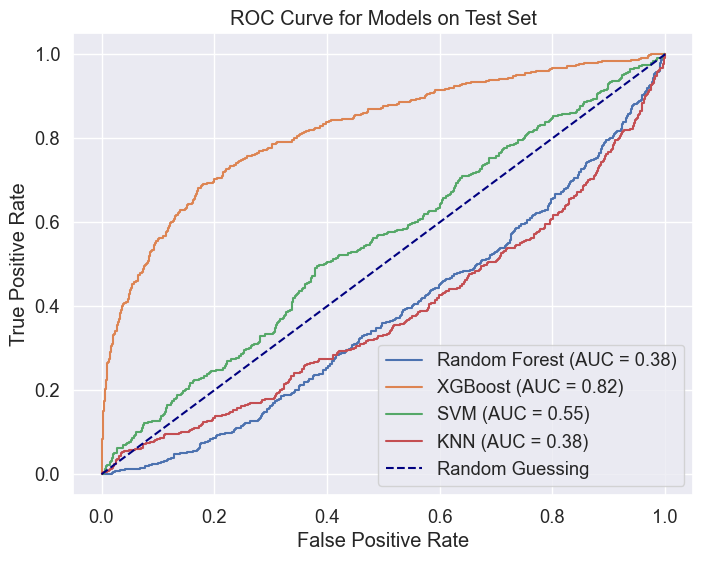

In [48]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))

# Iterating over each model
for model_name, model in models.items():
    
    try:
        if model_name == 'XGBoost':
            # Fit XGBoost model before predicting
            model.fit(X_train, y_train)
            y_score = model.predict_proba(X_test)[:, 1]  # Predict probabilities directly
        elif hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        elif model_name in ['Random Forest', 'SVM']:
            # For anomaly detection models, use the negative of the decision function as the score
            y_score = model.decision_function(X_test_scaled)
            y_score = -y_score
        elif model_name == 'KNN':
            # For KNN, we use the distance to the nearest neighbors as the anomaly score
            distances, _ = model.kneighbors(X_test)
            y_score = distances.mean(axis=1)
        else:
            raise AttributeError("Model does not have predict_proba or decision_function method")
        
        # Computing ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plotting ROC curve
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    except NotFittedError:
        print(f"Model {model_name} is not fitted yet.")

# Plotting ROC curve for random guessing (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')

# Setting labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Models on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Interpretation of the ROC curves and AUC

The best performers among the selected models were  XGBoost (0.82). The others were lower in their performance scale, SVM (0.55) weren't too far apart. Random Forest and KNN performed poorly among the four models used (0.38)

<div class="alert alert-block alert-success">
    <h2>Conclusion: Comparison of All Three Solutions</h2>
</div>

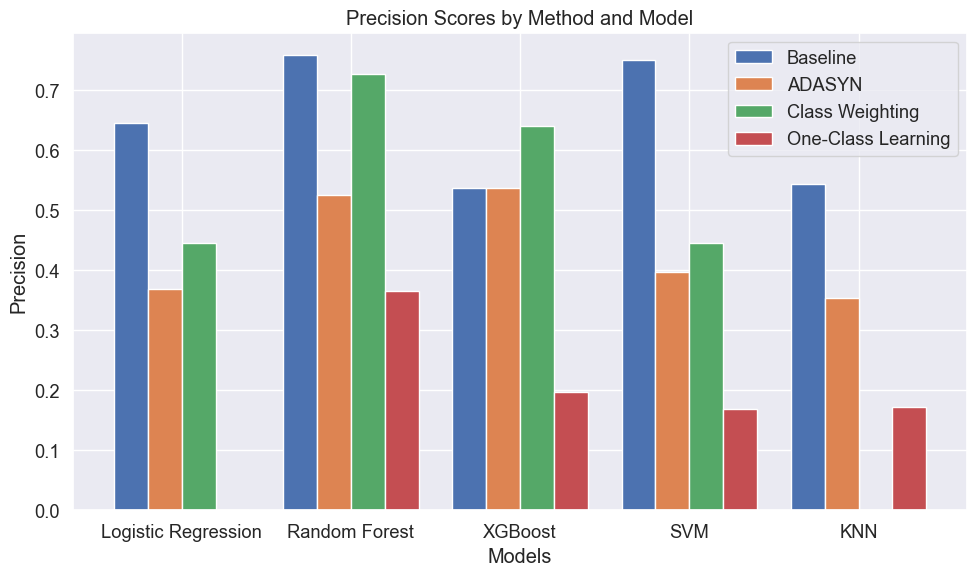

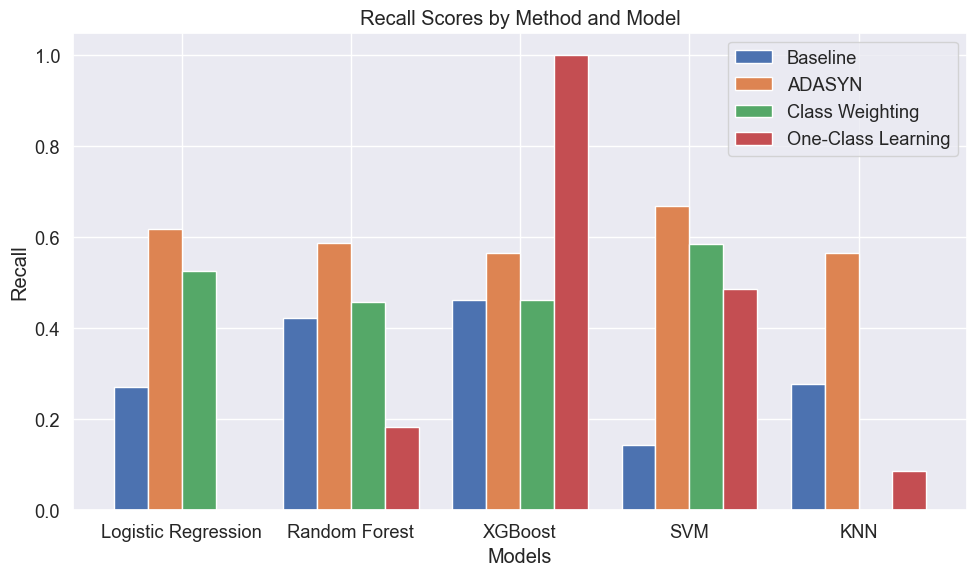

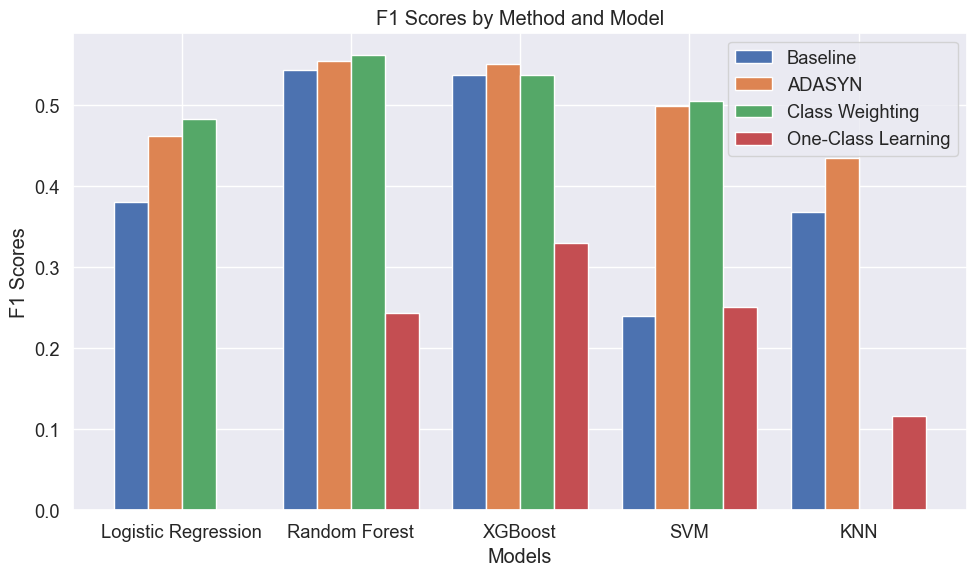

In [69]:
methods = ['Baseline', 'ADASYN', 'Class Weighting', 'One-Class Learning']
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']
precision_values = [
    [0.645570, 0.758294, 0.536341, 0.750000, 0.544041],
    [0.368504, 0.526066, 0.536341, 0.397799, 0.353719],
    [0.446188, 0.726891, 0.641026, 0.445565, 0],
    [0, 0.365079, 0.197595, 0.168962, 0.171875]
]

recall_values = [
    [0.269841, 0.423280, 0.462963, 0.142857, 0.277778],
    [0.619048, 0.587302, 0.566138, 0.669312, 0.566138],
    [0.526455, 0.457672, 0.462963, 0.584656, 0],
    [0, 0.182540, 1.000000, 0.486772, 0.087302]
]

f1_values = [
    [0.380597, 0.543294, 0.537634, 0.240000, 0.367776],
    [0.461994, 0.555000, 0.550837, 0.499014, 0.435402],
    [0.483010, 0.561688, 0.537634, 0.505721, 0],
    [0, 0.243386, 0.329987, 0.250852, 0.115789]
]


num_methods = len(methods)
num_models = len(models)
bar_width = 0.2
index = np.arange(num_models)

# Plotting
plt.figure(figsize=(10, 6))

# Plotting precision
for i in range(num_methods):
    plt.bar(index + i * bar_width, precision_values[i], bar_width, label=methods[i])

plt.xlabel('Models')
plt.ylabel('Precision')
plt.title('Precision Scores by Method and Model')
plt.xticks(index + bar_width * (num_methods - 1) / 2, models)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting recall
plt.figure(figsize=(10, 6))

for i in range(num_methods):
    plt.bar(index + i * bar_width, recall_values[i], bar_width, label=methods[i])

plt.xlabel('Models')
plt.ylabel('Recall')
plt.title('Recall Scores by Method and Model')
plt.xticks(index + bar_width * (num_methods - 1) / 2, models)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting F1 score
plt.figure(figsize=(10, 6))

for i in range(num_methods):
    plt.bar(index + i * bar_width, f1_values[i], bar_width, label=methods[i])

plt.xlabel('Models')
plt.ylabel('F1 Scores')
plt.title('F1 Scores by Method and Model')
plt.xticks(index + bar_width * (num_methods - 1) / 2, models)
plt.legend()
plt.tight_layout()
plt.show()

#### Interpreting the Comparison of the Models

After careful evaluation of the performance metrics for each approach and each model's results within those approaches, we observed the following trends:

The Baseline approach with Random Forest model achieves the highest precision (>0.75), however, the recall and F1 scores hold significance too. The recall for this approach and model is much less, lowering the overall credibility of the model.

In ADASYN, we observed a significant improvement the performance of the models by balancing the classes. Random Forest and XGBoost were the top performers in this scenario.

Class Weighting shows a strong overall performance in terms of the F1 scores. Random Forest was the best performing model here with highest F1 score, followed by XGBoost and SVM.

The One-Class Learning approach performed below average, with XGBoost being the best performer among all the models.




We arrived to the following conclusion:

Class Weighting in general gave better results in terms of F1 scores, especially Random Forest. This would be a preferred approach to select with either one of the models mentioned. 

However, we will recommend using Random Forest with all four approaches as it gave us good results due to its overall strong performance in recall and F1 score metrics. The best model for this dataset was ADASYN with Random Forest as it provides the best balance between precision and recall, leading to the second highest F1 score. We recommend using this approach for this Customer Churn Analysis dataset.